In [1]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(platetools)))
suppressWarnings(suppressPackageStartupMessages(library(gridExtra)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(viridis)))
suppressWarnings(suppressPackageStartupMessages(library(argparser)))    
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))

In [2]:
# generate a platemap plot for the meta data
# read in the platemap data
platemap_df_path <- "../../../data/Interstellar_plate2_platemap.csv"
# aggregate data
PBMC_aggregate_path <- file.path("../../../data/PBMC_preprocessed_sc_norm_aggregated.parquet")
SHSY5Y_aggregate_path <- file.path("../../../data/SHSY5Y_preprocessed_sc_norm_aggregated.parquet")

# read in the platemap data
PBMC_df <- arrow::read_parquet(PBMC_aggregate_path)
SHSY5Y_df <- arrow::read_parquet(SHSY5Y_aggregate_path)
platemap_df <- read.csv(platemap_df_path)
# get the metadata for the PBMC data
PBMC_df <- PBMC_df %>% 
  dplyr::select("Metadata_Well","oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
# get the metadata for the SHSY5Y data
SHSY5Y_df <- SHSY5Y_df %>% 
  dplyr::select("Metadata_Well","oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
# concatenate the two dataframes
df <- rbind(PBMC_df, SHSY5Y_df)
# merge the platemap data with df on the well column
platemap_df1 <- merge(platemap_df, df, by.x = "well_id", by.y = "Metadata_Well", all.x = TRUE)



# if cell_type is blank, set it to "blank"
platemap_df$cell_type[platemap_df$cell_type == ""] <- ""
# if treatment is blank, set it to "blank"
platemap_df$inducer1[platemap_df$inducer1 == ""] <- ""
# replace the "" with ""
platemap_df$inducer2[platemap_df$inducer2 == ""] <- ""
# replace the "" with ""
platemap_df$inhibitor[platemap_df$inhibitor == ""] <- ""
# replace the "" with ""
platemap_df$inhibitor_concentration[platemap_df$inhibitor_concentration == 'NA'] <- ""
platemap_df$inhibitor_concentration[is.na(platemap_df$inhibitor_concentration)] <- ""
platemap_df$inducer2_concentration[is.na(platemap_df$inducer2_concentration)] <- ""
platemap_df$inducer2[is.na(platemap_df$inducer2)] <- ""
# replace the "" with ""
platemap_df$inducer1_concentration[platemap_df$inducer1_concentration == 'NA'] <- ""
platemap_df$inducer2_concentration[platemap_df$inducer2_concentration == 'NA'] <- ""
# replace NA with ""
platemap_df$inducer1_concentration[platemap_df$inducer1_concentration == 'NA'] <- ""

In [3]:
# remove SHSY5Y data
platemap_df <- platemap_df[platemap_df$cell_type == "PBMC",]

In [4]:

# define save path
platemap_path <- file.path("../figures/")
# make path if it doesn't exist
if (!dir.exists(platemap_path)){
    dir.create(platemap_path)
}

In [5]:
width <- 10
height <- 7
options(repr.plot.width = width, repr.plot.height = height)

In [6]:

# add inducer 1 to inducer 1 concentration
platemap_df$inducer1_conc <- paste(platemap_df$inducer1, platemap_df$inducer1_concentration, platemap_df$inducer1_concentration_unit, sep = " ")
platemap_df$inducer2_conc <- paste(platemap_df$inducer2, platemap_df$inducer2_concentration,platemap_df$inducer2_concentration_unit, sep = " ")
# add inducer1_conc to inducer2_conc if inducer2_conc is not blank
platemap_df$inducer_conc <- ifelse(
    platemap_df$inducer2_conc == '  ',
    platemap_df$inducer1_conc, 
    paste(platemap_df$inducer1_conc, 
    platemap_df$inducer2_conc, 
    sep = " + "))

# add inhibitor to inhibitor concentration
platemap_df$inhibitor_conc <- paste(platemap_df$inhibitor, platemap_df$inhibitor_concentration,platemap_df$inhibitor_concentration_unit, sep = " ")

In [7]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inducer_conc[platemap_df$inducer_conc == "media ctr  µg/ml +   "] <- "Media"
platemap_df$inducer_conc[platemap_df$inducer_conc == "media ctr  "] <- "Media"
platemap_df$inducer_conc[platemap_df$inducer_conc == "media ctr  µg/ml"] <- "Media"
platemap_df$inducer_conc[platemap_df$inducer_conc == '  '] <- "Blank"
platemap_df$cell_type[platemap_df$cell_type == ' '] <- "Blank"
# replace 'flagellin 1.000 ' with 'flagellin 1.000 µg/ml
platemap_df$inducer_conc[platemap_df$inducer_conc == "Flagellin 1.000 "] <- "Flagellin 1.000 µg/ml"
# replace disulfiram 2.5µM µM with disulfiram 2.500 µM
platemap_df$inducer_conc[platemap_df$inducer_conc == "Disulfiram 2.5µM µM"] <- "Disulfiram 2.500 µM"

platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == '  '] <- "Blank"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'DMSO 0.00025 %'] <- "DMSO 0.025 %"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'Media ctr  '] <- "Media"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'Media  '] <- "Media"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'DMSO 1 %'] <- "DMSO 1.0 %"
unique(platemap_df$inhibitor_conc)
# redefine the values and order
platemap_df$inducer_conc <- factor(
    platemap_df$inducer_conc, 
    levels = c(
    
    'Media',
    'DMSO 0.100 %',

    'LPS 0.010 µg/ml',
    'LPS 0.100 µg/ml',
    'LPS 1.000 µg/ml',
    'LPS 10.000 µg/ml',
    'LPS 100.000 µg/ml',
    'LPS 1.000 µg/ml + Nigericin 1 µM',
    'LPS 1.000 µg/ml + Nigericin 3 µM',
    'LPS 1.000 µg/ml + Nigericin 10 µM',

    'LPS 100.000 µg/ml + Nigericin 1 µM',
    'LPS 100.000 µg/ml + Nigericin 3 µM',
    'LPS 100.000 µg/ml + Nigericin 10 µM',

    'Flagellin 0.100 µg/ml',
    'Flagellin 1.000 µg/ml',

    'Disulfiram 0.100 µM',
    'Disulfiram 1.000 µM',
    'Disulfiram 2.500 µM',

    

    

    'H2O2 100.000 nM',
    'H2O2 100.000 µM',


    'Thapsigargin 1.000 µM',
    'Thapsigargin 10.000 µM',
    
    'Topotecan 5.000 nM',
    'Topotecan 10.000 nM',
    'Topotecan 20.000 nM',
    'Blank'
    )
)

[1] "DMSO 0.025 %"      "Disulfiram 0.1 µM" "Disulfiram 1 µM"  
[4] "Disulfiram 2.5 µM" "Z-VAD-FMK 100 µM"  "Media"            
[7] "DMSO 1.0 %"        "Z-VAD-FMK 30 µM"

In [8]:
# 9 colors
# col 1 - 3 hues
colorgrad1 <- c("white", "grey", "#585858")
# col 2 - 5 hues color ramp 5 hues
colorgrad2 <- colorRampPalette(c("pink", "darkred"))(11)
# col 3 - 3 hues
colorgrad3 <- colorRampPalette(c("yellow", "brown"))(3)
# col 4 - 3 hues
colorgrad4 <- colorRampPalette(c("lightblue", "darkblue"))(6)
# col 5 - 2 hues
colorgrad5 <- colorRampPalette(c("lightgreen", "darkgreen"))(2)
# col 6 - 3 hues
colorgrad6 <- colorRampPalette(c("purple", "#2e004b"))(3)
# col 7 - 2 hues
colorgrad7 <- colorRampPalette(c("cyan", "darkcyan"))(4)
# col 8 - 2 hues
colorgrad8 <- colorRampPalette(c("#ebb676", "darkorange"))(2)
# col 9 - 3 hues
colorgrad9 <- colorRampPalette(c("magenta", "#833b83"))(3)

In [9]:
# define the colors
colors <- c(
    "Blank" = colorgrad1[1],
    "Media" =colorgrad1[2],
    "DMSO 0.100 %" = colorgrad1[3],
    "LPS 0.010 µg/ml" = colorgrad2[1],
    "LPS 0.100 µg/ml" = colorgrad2[2],
    "LPS 1.000 µg/ml" =colorgrad2[3],
    "LPS 10.000 µg/ml" =colorgrad2[4],
    "LPS 100.000 µg/ml" = colorgrad2[5],
    "LPS 1.000 µg/ml + Nigericin 1 µM" = colorgrad2[6],
    "LPS 1.000 µg/ml + Nigericin 3 µM" = colorgrad2[7],
    "LPS 1.000 µg/ml + Nigericin 10 µM" = colorgrad2[8],
    "LPS 100.000 µg/ml + Nigericin 1 µM" = colorgrad2[9],
    "LPS 100.000 µg/ml + Nigericin 3 µM" = colorgrad2[10],
    "LPS 100.000 µg/ml + Nigericin 10 µM" = colorgrad2[11],
    "Flagellin 0.100 µg/ml" = colorgrad5[1],
    "Flagellin 1.000 µg/ml" = colorgrad5[2],
    "Disulfiram 0.100 µM" = colorgrad4[3],
    "Disulfiram 1.000 µM" = colorgrad4[4],
    "Disulfiram 2.500 µM" = colorgrad4[5],
    "H2O2 100.000 nM" = colorgrad7[1],
    "H2O2 100.000 µM" = colorgrad7[2],
    "Thapsigargin 1.000 µM" = colorgrad8[1],
    "Thapsigargin 10.000 µM" = colorgrad8[2],
    "Topotecan 5.000 nM" = colorgrad9[1],
    "Topotecan 10.000 nM" = colorgrad9[2],
    "Topotecan 20.000 nM" = colorgrad9[3]
)


Warning message:
“Warning: Your well label count ( 154 ) covers less than half the selected plate( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


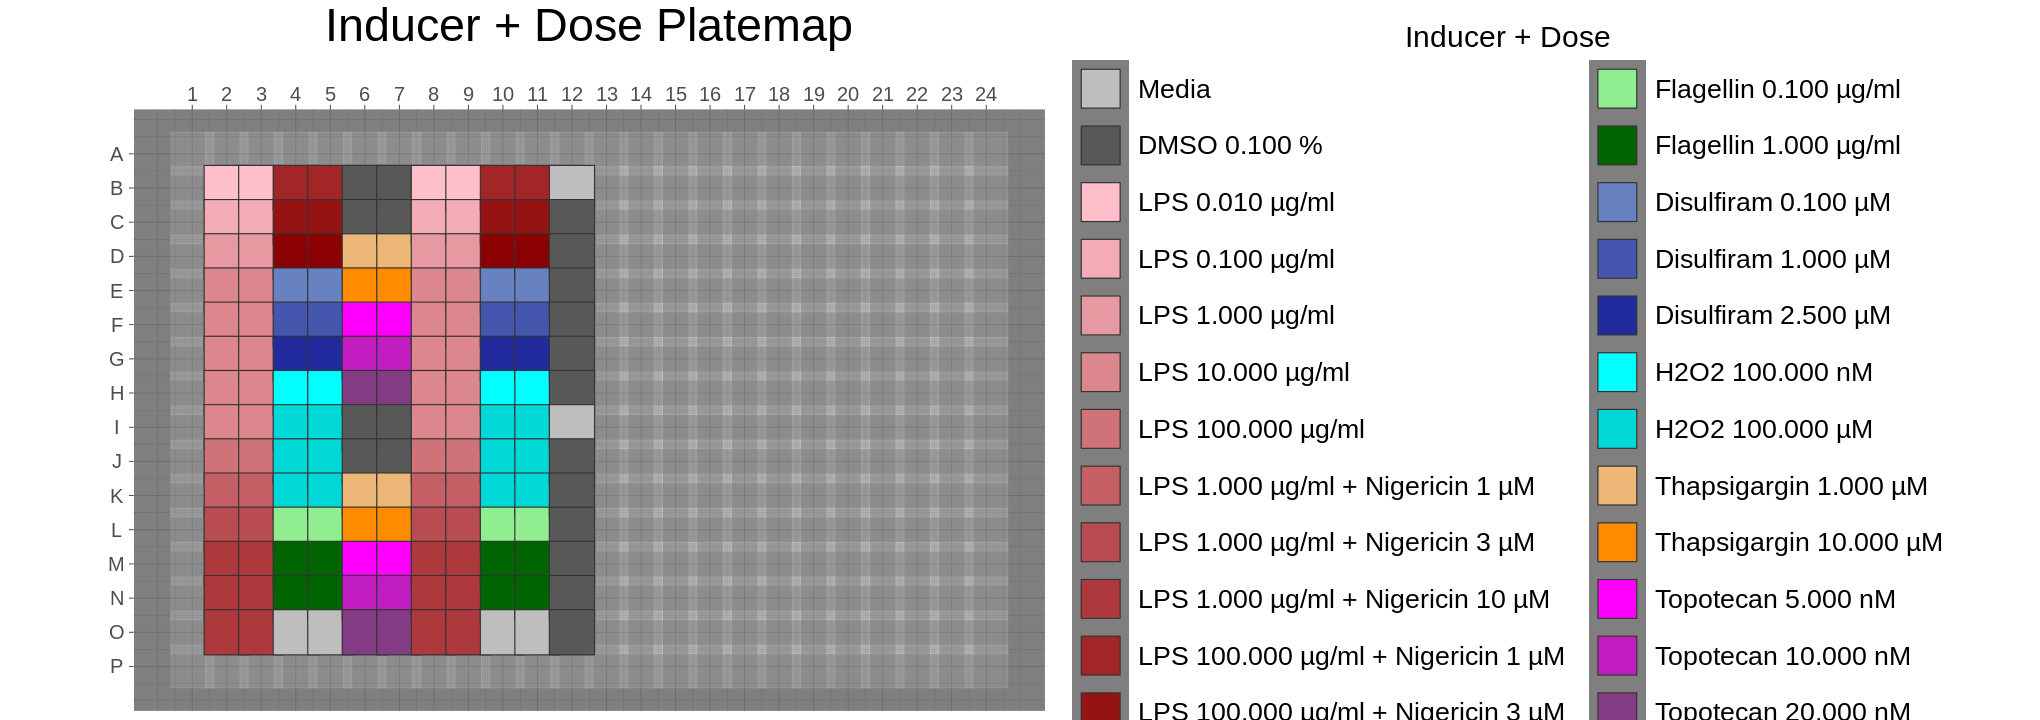

In [10]:
# define pallete
# viridis colors
viridis_pal_custom <- viridis::viridis_pal(option = 'C')(20)

width <- 17
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
inducer_well_dose_platemap <- file.path(paste0(platemap_path,"inducer_well_dose_platemap.png"))
# if path does not exist, create it
platemap_plot_inducer_dose <- (
    raw_map(
        data = platemap_df$inducer_conc,
        well = platemap_df$well_id,
        plate = 384,
        size = 14)
    + theme_dark() 
    # fill the color by dose

        + labs(fill = "Inducer + Dose")
        # remove shape legend from plot
        + guides(fill = guide_legend(override.aes = list(size = 12),ncol = 2))
        + guides(shape = guide_legend(override.aes = list(size = 12),nrow = 1))
        + theme(
            legend.title = element_text(size = 18,hjust = 0.5),
            legend.text = element_text(size = 16)
        )
        # make the blank well grey
        + scale_fill_manual(
            values = colors
            )
        # make shape legend horizontal
        # title
    + ggtitle("Inducer + Dose Platemap")
    + theme(plot.title = element_text(size = 28, hjust = 0.5))
    + theme(axis.text.x = element_text(size = 12,vjust = 0.5, hjust=0.5))
    + theme(axis.text.y = element_text(size = 12, vjust = 0.5, hjust=0.5))
    
)
platemap_plot_inducer_dose


In [11]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inhibitor[platemap_df$inhibitor == "Media ctr"] <- "Media"
platemap_df$inhibitor[platemap_df$inhibitor == " "] <- "Blank"

In [12]:
# create a new column that is the combination of inducer and inducer concentration
platemap_df$inhibitor_conc <- paste0(platemap_df$inhibitor, " ", platemap_df$inhibitor_concentration, " ",  platemap_df$inhibitor_concentration_unit)
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == " "] <- "Blank"


In [13]:
viridis_pal_custom <- viridis::viridis_pal(option = "C")(7)

In [14]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "Media ctr NA "] <- "media ctr"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "Media NA "] <- "Media ctr"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == " "] <- "Blank"

platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == ""] <- "Blank"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == '  '] <- "Blank"
platemap_df$cell_type[platemap_df$cell_type == ""] <- "Blank"
# replace  'DMSO 0.00025 %' with 'DMSO 0.025 %'
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "DMSO 0.00025 %"] <- "DMSO 0.025 %"
unique(platemap_df$inhibitor_conc)
# make the inhibitor_conc a factor
platemap_df$inhibitor_conc <- factor(
    platemap_df$inhibitor_conc, 
    levels = c(
    'Blank',
    'Media  ',
    'DMSO 0.025 %',
    'DMSO 1 %',
    'Disulfiram 0.1 µM',
    'Disulfiram 1 µM',
    'Disulfiram 2.5 µM',
    'Z-VAD-FMK 30 µM',
    'Z-VAD-FMK 100 µM'
    )
)

[1] "DMSO 0.025 %"      "Disulfiram 0.1 µM" "Disulfiram 1 µM"  
[4] "Disulfiram 2.5 µM" "Z-VAD-FMK 100 µM"  "Media  "          
[7] "DMSO 1 %"          "Z-VAD-FMK 30 µM"

Warning message:
“Warning: Your well label count ( 154 ) covers less than half the selected plate( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


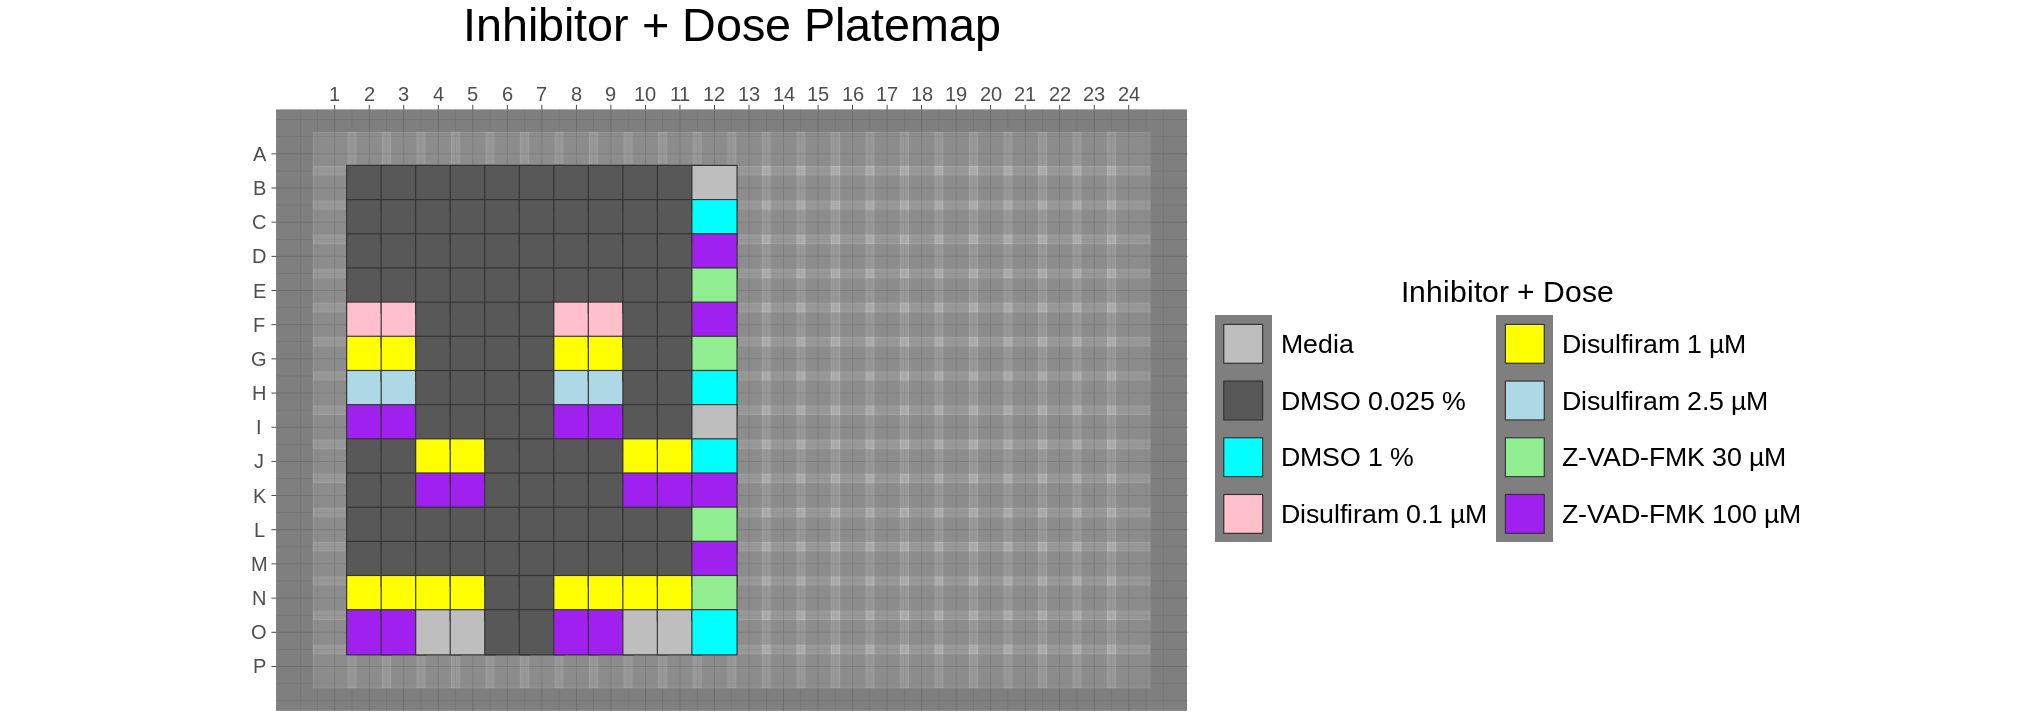

In [15]:
width <- 17
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
inhibtor_well_dose_platemap <- file.path(paste0(platemap_path,"inhibtor_well_dose_platemap.png"))
# if path does not exist, create it
platemap_plot_inhibitor_dose <- (
    raw_map(
        data = platemap_df$inhibitor_conc,
        well = platemap_df$well_id,
        plate = 384,
        size = 14)
    + theme_dark() 

        # change the size of the shapes in the legend and plot
    # 2 column legend
    + labs(fill = "Inhibitor + Dose")
    # change legend text size for fill
    
    + guides(shape = guide_legend(override.aes = list(size = 12), nrow = 1))
    + guides(fill = guide_legend(override.aes = list(size = 12),ncol = 2))
    + theme(
        legend.title = element_text(size = 18,hjust = 0.5),
        legend.text = element_text(size = 16),
    )
    # make the blank well grey
        + scale_fill_manual(
            values = c(
                'Blank' = colorgrad1[1],
                'Media  ' = colorgrad1[2],
                'DMSO 0.025 %' = colorgrad1[3],
                'DMSO 1 %' = colorgrad7[1],
                'Disulfiram 0.1 µM' = colorgrad2[1],
                'Disulfiram 1 µM' = colorgrad3[1],
                'Disulfiram 2.5 µM' = colorgrad4[1],
                'Z-VAD-FMK 30 µM' = colorgrad5[1],
                'Z-VAD-FMK 100 µM' = colorgrad6[1]
            )
        )

    # x axis ticks larger
    + theme(legend.title = element_text(size = 18))
    + theme(axis.text.x = element_text(size = 12,vjust = 0.5, hjust=0.5))
    + theme(axis.text.y = element_text(size = 12, vjust = 0.5, hjust=0.5))
    # title
    + ggtitle("Inhibitor + Dose Platemap")
    + theme(plot.title = element_text(size = 28, hjust = 0.5))
    
)
platemap_plot_inhibitor_dose 


### Create the cell count figures

In [16]:
# output figure directory
figs_dir <- file.path("..","figures")
# make directory if doesn't exist
if (!dir.exists(figs_dir)) dir.create(figs_dir)

In [17]:
cell_type <- "PBMC"
# set the path to the cell count data
cell_count_file_PBMC <- file.path(paste0("../../../1.Exploratory_Data_Analysis/results/",cell_type,"_cell_counts.parquet"))

# Read in the cell count data
cell_count_df_PBMC <- arrow::read_parquet(cell_count_file_PBMC)
head(cell_count_df_PBMC)

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Metadata_number_of_singlecells,Metadata_Well,Metadata_Treatment,__index_level_0__
<chr>,<int>,<chr>,<chr>,<int>
LPS_0.010_ug_per_ml_DMSO_0.025_%,47666,B02,LPS,0
LPS_0.010_ug_per_ml_DMSO_0.025_%,47666,B02,LPS,1
LPS_0.010_ug_per_ml_DMSO_0.025_%,47666,B02,LPS,2
LPS_0.010_ug_per_ml_DMSO_0.025_%,47666,B02,LPS,3
LPS_0.010_ug_per_ml_DMSO_0.025_%,47666,B02,LPS,4
LPS_0.010_ug_per_ml_DMSO_0.025_%,47666,B02,LPS,5


In [18]:
# aggregate the cell counts oneoneb_Metadata_Treatment_Dose_Inhibitor_Dose with mean and sd
cell_count_df_agg_PBMC <- cell_count_df_PBMC %>%
  group_by(oneb_Metadata_Treatment_Dose_Inhibitor_Dose) %>%
  summarize(mean = mean(Metadata_number_of_singlecells), sd = sd(Metadata_number_of_singlecells), n = n(), CI = 1.96*sd/sqrt(n))
head(cell_count_df_agg_PBMC)

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,mean,sd,n,CI
<chr>,<dbl>,<dbl>,<int>,<dbl>
Disulfiram_0.100_uM_DMSO_0.025_%,59798.98,5302.585,237372,21.331872
Disulfiram_1.000_uM_DMSO_0.025_%,57762.78,2287.582,230692,9.335046
Disulfiram_2.500_uM_DMSO_0.025_%,61719.79,5416.595,244937,21.451381
DMSO_0.100_%_DMSO_0.025_%,61465.38,4630.650,488659,12.983599
DMSO_0.100_%_DMSO_1.000_%,59080.15,1962.549,236055,7.917169
DMSO_0.100_%_Z-VAD-FMK_100.000_uM,53159.71,4573.952,210870,19.522719


In [19]:

# mutate the names of each treatment
cell_count_df_agg_PBMC <- cell_count_df_agg_PBMC %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Media' ~ "Media - Media",
    ))


In [20]:

# split the oneb_Metadata_Treatment_Dose_Inhibitor_Dose into two columns by the " - " delimiter
cell_count_df_agg_PBMC <- cell_count_df_agg_PBMC %>%
    separate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)
# replace the inhibitor NA with Media
cell_count_df_agg_PBMC$inhibitor <- ifelse(is.na(cell_count_df_agg_PBMC$inhibitor), "Media", cell_count_df_agg_PBMC$inhibitor)


In [21]:
cell_count_df_agg_PBMC$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(cell_count_df_agg_PBMC$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, levels = c(
    'Media - Media',   
    'DMSO 0.1% - DMSO 0.025%',
    'DMSO 0.1% - DMSO 1.0%',

    'Disulfiram 0.1 uM - DMSO 0.025%',
    'Disulfiram 1.0 uM - DMSO 0.025%',
    'Disulfiram 2.5 uM - DMSO 0.025%',

    'DMSO 0.1% - Z-VAD-FMK 30.0 uM' ,
    'DMSO 0.1% - Z-VAD-FMK 100.0 uM' ,   
       
    'Flagellin 0.1 ug/ml - DMSO 0.025%'  , 
    'Flagellin 1.0 ug/ml - DMSO 0.025%' ,  
    'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM'  ,  
  

    'H2O2 100.0 nM - DMSO 0.025%'   ,
    'H2O2 100.0 uM - DMSO 0.025%'   ,  
    'H2O2 100.0 uM - Disulfiram 1.0 uM'   , 
    'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM'  ,  
   


    'LPS 0.01 ug/ml - DMSO 0.025%'  ,  
    'LPS 0.1 ug/ml - DMSO 0.025%'  ,  
    'LPS 1.0 ug/ml - DMSO 0.025%'  ,
    'LPS 10.0 ug/ml - DMSO 0.025%' ,

    'LPS 10.0 ug/ml - Disulfiram 0.1 uM'  ,  
    'LPS 10.0 ug/ml - Disulfiram 1.0 uM'  ,  
    'LPS 10.0 ug/ml - Disulfiram 2.5 uM'  ,  
    'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM' ,

    'LPS 100.0 ug/ml - DMSO 0.025%'   ,
    'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%' , 
    'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%'  ,
    'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%'  ,

    'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM'  ,
    'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM'  ,
    

    'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%'   ,
    'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%'  ,
    'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%'  ,

    
    'Thapsigargin 1.0 uM - DMSO 0.025%'  ,
    'Thapsigargin 10.0 uM - DMSO 0.025%',
    'Topotecan 5.0 nM - DMSO 0.025%',
    'Topotecan 10.0 nM - DMSO 0.025%' , 
    'Topotecan 20.0 nM - DMSO 0.025%' 
)
)

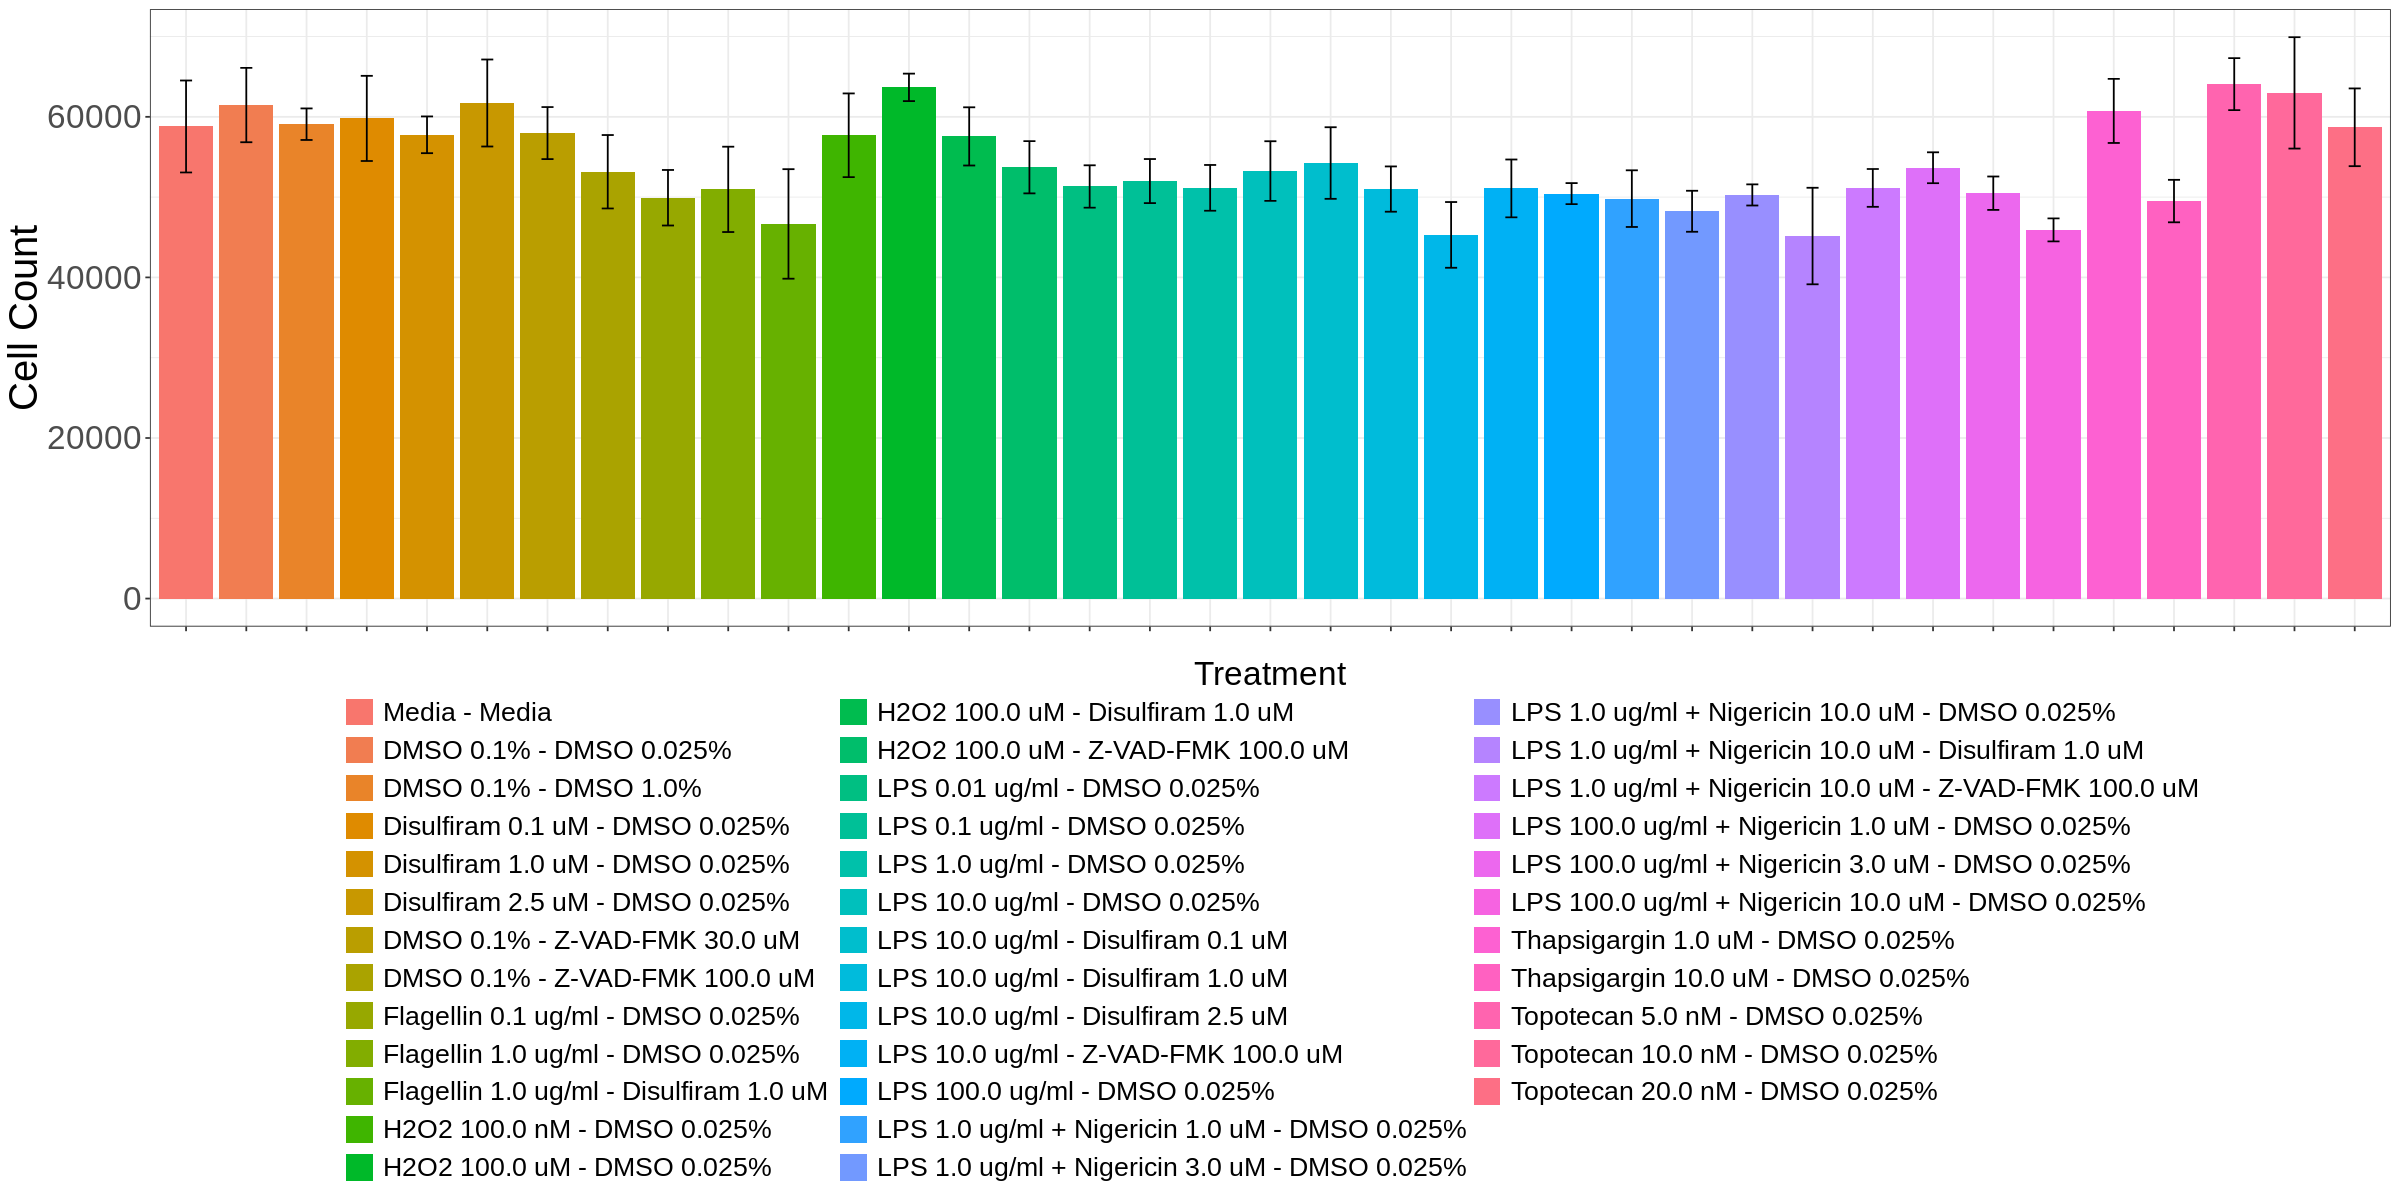

In [22]:
# set plot dimensions
width <- 20
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
# plot the data in a barplot
cell_count_bar <- (
    ggplot(
        data = cell_count_df_agg_PBMC,
        aes(
            x = oneb_Metadata_Treatment_Dose_Inhibitor_Dose,
            y = mean,
            fill = oneb_Metadata_Treatment_Dose_Inhibitor_Dose,
        )
    )
    + geom_bar(stat = "identity", position = "dodge")
    # add scatter plot points for each inhibitor mean value with error bars
    + theme_bw()
    # rotate the x axis labels
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    # add error bars
    + geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), width = 0.2)
       + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
    
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    # remove x axis ticks
    + theme(axis.text.x = element_blank())
    # change the legend title
    + labs(fill = "Treatment", y = "Cell Count")
    # change legend title position to top
    + theme(legend.title.position = "top")
    + theme(legend.position = "bottom")
    # remove the x axis label
    + theme(axis.title.x = element_blank())
    # set the legend columns to 4
    + guides(fill = guide_legend(ncol = 3))
    # remove the title
    + theme(plot.title = element_blank())
    # change the y axis text size
    + theme(axis.text.y = element_text(size = 20))
    + theme(axis.title.y = element_text(size = 24))

)
cell_count_bar

In [23]:
head(cell_count_df_agg_PBMC)

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,inducer,inhibitor,mean,sd,n,CI
<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
Disulfiram 0.1 uM - DMSO 0.025%,Disulfiram 0.1 uM,DMSO 0.025%,59798.98,5302.585,237372,21.331872
Disulfiram 1.0 uM - DMSO 0.025%,Disulfiram 1.0 uM,DMSO 0.025%,57762.78,2287.582,230692,9.335046
Disulfiram 2.5 uM - DMSO 0.025%,Disulfiram 2.5 uM,DMSO 0.025%,61719.79,5416.595,244937,21.451381
DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,61465.38,4630.650,488659,12.983599
DMSO 0.1% - DMSO 1.0%,DMSO 0.1%,DMSO 1.0%,59080.15,1962.549,236055,7.917169
DMSO 0.1% - Z-VAD-FMK 100.0 uM,DMSO 0.1%,Z-VAD-FMK 100.0 uM,53159.71,4573.952,210870,19.522719


In [24]:
# Read in the cell count data
cell_count_df_PBMC <- arrow::read_parquet(cell_count_file_PBMC)
# aggregate the cell counts oneoneb_Metadata_Treatment_Dose_Inhibitor_Dose with mean and sd
cell_count_df_well_PBMC <- cell_count_df_PBMC %>%
  group_by(Metadata_Well, oneb_Metadata_Treatment_Dose_Inhibitor_Dose) %>%
  summarize(mean = mean(Metadata_number_of_singlecells))
# rename mean to n where n is the count of cells per well
cell_count_df_well_PBMC <- rename(cell_count_df_well_PBMC, n = mean)

head(cell_count_df_well_PBMC)

`summarise()` has grouped output by 'Metadata_Well'. You can override using the
`.groups` argument.


Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,n
<chr>,<chr>,<dbl>
B02,LPS_0.010_ug_per_ml_DMSO_0.025_%,47666
B03,LPS_0.010_ug_per_ml_DMSO_0.025_%,49570
B04,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,56354
B05,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,53455
B06,DMSO_0.100_%_DMSO_0.025_%,65025
B07,DMSO_0.100_%_DMSO_0.025_%,65600


In [25]:
# load the SHSY5Y cell count data
cell_count_file_shsy5y <- file.path(paste0("../../../1.Exploratory_Data_Analysis/results/SHSY5Y_cell_counts.parquet"))
cell_count_df_shsy5y <- arrow::read_parquet(cell_count_file_shsy5y)
# get the counts for each well
cell_count_df_shsy5y_well <- cell_count_df_shsy5y %>%
  group_by(Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose) %>%
  summarize(mean = mean(Metadata_number_of_singlecells))
# rename mean to n where n is the count of cells per well
cell_count_df_shsy5y_well <- rename(cell_count_df_shsy5y_well, n = mean)
head(cell_count_df_shsy5y_well)

`summarise()` has grouped output by 'Metadata_Well'. You can override using the
`.groups` argument.


Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,n
<chr>,<chr>,<dbl>
B13,Media,3780
B14,DMSO_0.100_%_DMSO_0.025_%,4306
B15,DMSO_0.100_%_DMSO_0.025_%,4534
B16,LPS_0.010_ug_per_ml_DMSO_0.025_%,4020
B17,LPS_0.010_ug_per_ml_DMSO_0.025_%,3819
B18,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,3460


In [26]:
# get the min max normalized counts for each cell type in a new column
cell_count_df_well_PBMC$cell_type <- "PBMC"
cell_count_df_well_PBMC$cell_count_norm <- (cell_count_df_well_PBMC$n - min(cell_count_df_well_PBMC$n))/(max(cell_count_df_well_PBMC$n) - min(cell_count_df_well_PBMC$n))
all_count_data <- cell_count_df_well_PBMC

In [27]:
# # merge the PBMC and SHSY5Y cell count data
# all_count_data <- rbind(cell_count_df_well_PBMC, cell_count_df_shsy5y_well)
# head(all_count_data)

In [28]:
# plate visualization using plate tools

# set plot dimensions
width <- 4
height <- 3
options(repr.plot.width = width, repr.plot.height = height)

suppressWarnings({ 
plate_replicate_gg_count_raw <-(
    platetools::raw_map(
        data = all_count_data$n,
        well = all_count_data$Metadata_Well,
        plate = 384,
        size = 10
    )
    + theme_dark() 
        + theme(
        legend.position = "bottom", 
        legend.direction = "horizontal",
        legend.text = element_text(size = 18),
        # increase legend length
        legend.key.width = unit(2, "cm"),
        )
    + theme(legend.title = element_text(size = 18))
    + theme(axis.text.x = element_text(size = 12,vjust = 0.5, hjust=0.5))
    + theme(axis.text.y = element_text(size = 12, vjust = 0.5, hjust=0.5))
    + ggplot2::scale_fill_gradient(
        name = "Cell count  ",
        low = "lightgreen",
        high = "darkgreen",
        limits = c(0, max(all_count_data$n))
    )
    + labs(title = "Raw Cell Count")
    + theme(title = element_text(size = 18, hjust = 0.5))

)
})

plate_replicate_gg_treatment_min_max <-(
    platetools::raw_map(
        data = all_count_data$cell_count_norm,
        well = all_count_data$Metadata_Well,
        plate = 384,
        size = 10
        
    )
    + theme_dark() 
    + theme(
        legend.position = "bottom", 
        legend.direction = "horizontal",
        legend.text = element_text(size = 18),
        # increase legend length
        legend.key.width = unit(2, "cm"),
        )
    + theme(legend.title = element_text(size = 18))
    + theme(axis.text.x = element_text(size = 12,vjust = 0.5, hjust=0.5))
    + theme(axis.text.y = element_text(size = 12, vjust = 0.5, hjust=0.5))
    # padding between the legend and legend title
    + theme(legend.margin = margin(t = 0, r = 2, b = 0, l = 2, unit = "cm"))

    + ggplot2::scale_fill_gradient(
        name = "Cell count  \n(min-max)   ",
        low = "lightgreen",
        high = "darkgreen",
        limits = c(0, max(all_count_data$cell_count_norm))
    )
    + labs(title = "Min-Max Normalized Cell Count")
    + theme(title = element_text(size = 18, hjust = 0.5,vjust = 0.5))

)

Warning message:
“Warning: Your well label count ( 154 ) covers less than half the selected plate( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


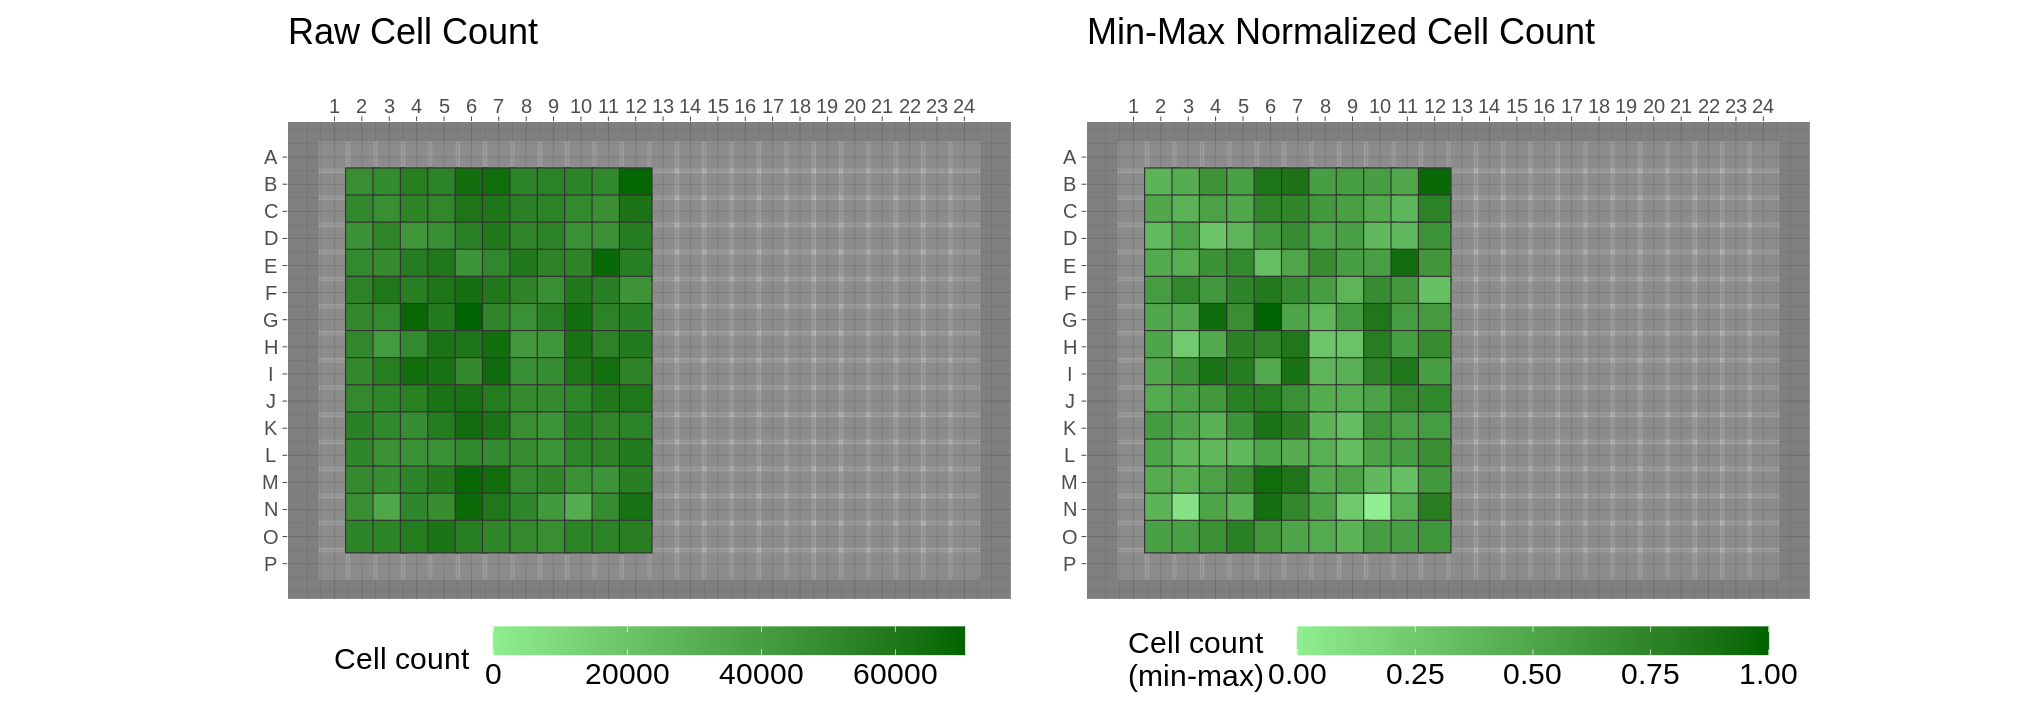

In [29]:
width <- 17
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
cell_counts_plots <- plate_replicate_gg_count_raw + plate_replicate_gg_treatment_min_max
cell_counts_plots

### Assemble the Final Figure!

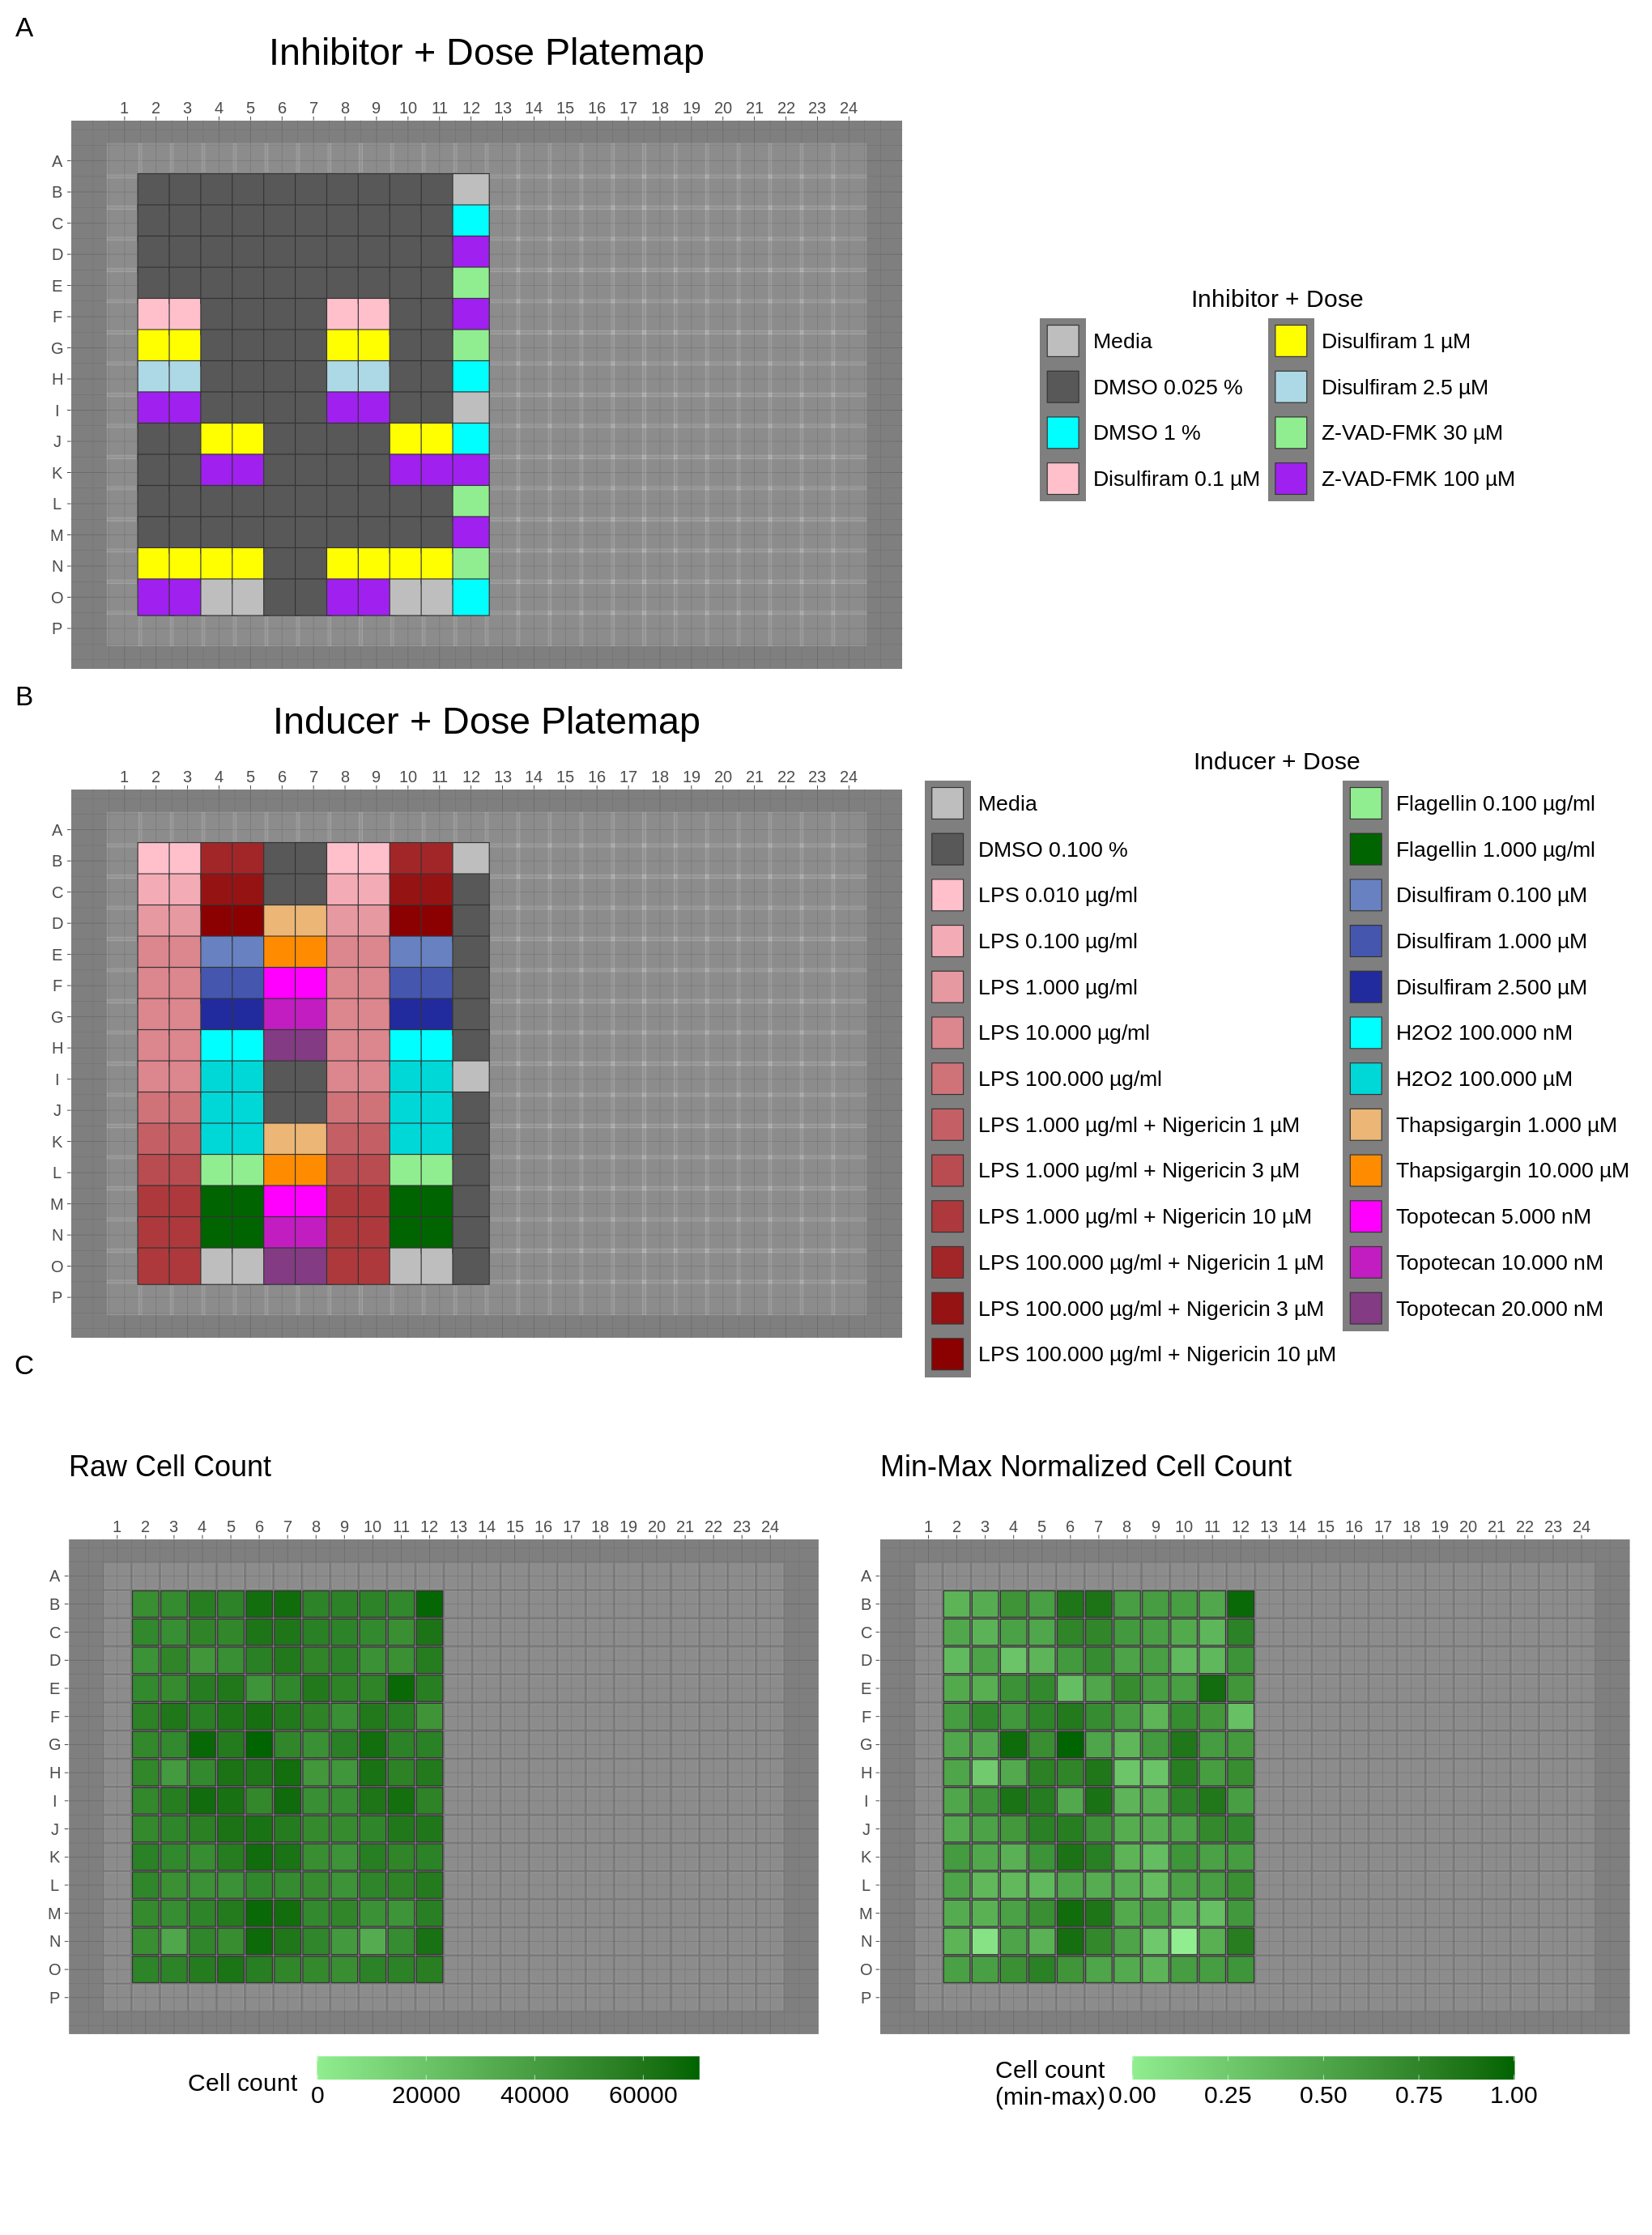

In [30]:
# pathwork for platemaps
width <- 17
height <- 23
options(repr.plot.width = width, repr.plot.height = height)

layout <- c(
    area(t=1, b=1, l=1, r=1),
    area(t=2, b=2, l=1, r=1),
    area(t=3, b=3, l=1, r=1)
)

patch_plot <- (
    platemap_plot_inhibitor_dose
    + platemap_plot_inducer_dose
    + wrap_elements(full = cell_counts_plots)
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))

)
patch_plot
# set save path for patchwork plot
patchwork_platemap_path <- file.path(paste0(platemap_path,"Platemaps_and_cell_counts_no_SHSY5Y.png"))
ggsave(patchwork_platemap_path, patch_plot, width=width, height=height, dpi=600)